Import das bibliotecas necessárias para execução e criação dos modelos

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91195003)

#for an easy reset backend session state
tf.keras.backend.clear_session()

In [3]:
#load dataset
def load_dataset(path):
    return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
    train_idx = np.arange(0,int(len(training)*(100-perc)/100))
    val_idx = np.arange(int(len(training)* (100-perc)/100+1),len(training))
    return train_idx, val_idx


In [5]:
#preparing the data for the LSTM
def prepare_data(df):
    df_aux = df.copy()
    df_aux["Date"] = pd.to_datetime(df_aux["Date"])
    df_aux = df_aux.set_index('Date')
    return df_aux


In [6]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    colunas = [x for x in df.columns if x != 'obitos']
    print(colunas)
    for col in colunas:
        df[[col]] = scaler.fit_transform(df[[col]])
    df[['obitos']] = scaler.fit_transform(df[['obitos']])
    
    return scaler

In [7]:
#plot learning curve
def plot_learning_curves(history, epochs):
    #accuracies and losses
    #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs_range = range(epochs)
    #creating figure
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,2)
    plt.plot(epochs_range,loss,label='Training Loss')
    plt.plot(epochs_range,val_loss,label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training/Validation Loss')
    plt.show()


In [8]:
#Plot time series data
def plot_confirmed_cases(data):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(data)), data)
    plt.title('Dataset Features')
    plt.ylabel('Valores')
    plt.xlabel('Semanas')
    plt.show()

In [9]:
#Preparing the dataset for the CNN
def to_supervised(df, timesteps):
    data = df.values
    X,y = list(), list()
    #iterate over the training set to create X and y
    dataset_size = len(data)
    for curr_pos in range(dataset_size):
        #end of the input sequence is the current position + the number of the timesteps of the input sequence
        input_index = curr_pos + timesteps
        #end of the labels corresponds to the end of the input sequence + 1
        label_index = input_index + 1
        #if we have enough data for this sequence
        if label_index < dataset_size:
            X.append(data[curr_pos:input_index,:])
            y.append(data[input_index:label_index,0])
            #using np.flot32 for GPU performance
    return np.array(X).astype('float32'), np.array(y).astype('float32')

In [10]:
#Building the model
def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [11]:
def build_model(timesteps, features, filters= 16, kernel_size=1, pool_size =2 ):
    #using the functional API
    inputs = tf.keras.layers.Input(shape=(timesteps, features))
    #microarchitecture
    x = tf.keras.layers.Conv1D(filters=filters, kernel_size = kernel_size, activation='relu', data_format = 'channels_last')(inputs)
    x = tf.keras.layers.AveragePooling1D(pool_size = pool_size, data_format = 'channels_first')(x)
    #last layers
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(filters)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    #the model
    cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')
    tf.keras.utils.plot_model(cnnModel,'cnnmodel.png', show_shapes=True)
    return cnnModel

In [12]:
def compile_and_fit(model, epochs, batch_size,learning_rate):
    #compile
    model.compile(loss=rmse, optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['mae',rmse])
    #fit
    hist_list = list()
    loss_list = list()
    #Time Series Cross Validator
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    for train_index, test_index in tscv.split(X):
        train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
        #build data
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        X_test, y_test = X[test_index], y[test_index]
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,shuffle=False)
        metrics = model.evaluate(X_test, y_test)

        plot_learning_curves(history, epochs)
        hist_list.append(history)

    return model, hist_list

In [13]:
def forecast(model, df, timesteps, multisteps, scaler):
    input_seq = df[-timesteps:].values #getting the last sequence of known value
    inp = input_seq
    forecasts = list()
    print(inp)
    #multistep tells us how many iterations we want to perform
    #i. e. how many days we want to predict
    for step in range(1, multisteps+1):
        #implement
        inp = inp.reshape(1, timesteps, n_variate)
        pred = model.predict(inp)
        yhat_inversed = scaler.inverse_transform(pred)
        forecasts.append(yhat_inversed)
        #prepare new input to forecast the next day
        # inp = np.append(inp[0], pred)        
        # inp = inp[-timesteps:]
        # list_pred = [pred[0][i] for i in range(len(pred[0]))]
        # print('list_yhat:')
        # print(list_pred)
        # inp= np.append(inp[0],[list_pred],axis=0) #adiciona previsão recente ao input
        # inp = inp[-timesteps:]#vai ao input buscar os ultimos timesteps registados
        # print(step)
        print(step)
            
    return forecasts

In [14]:
def plot_forecast(data, forecasts):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(data)),data["obitos"], color='green', label='Confirmed')
        
    fi=[]
    for f in forecasts:
        fi.append(f[0][0])
        print('Previsão:' + str(f))
    print(fi)
        
    plt.plot(range(len(data)-1,len(data)+len(fi)-1), fi, color='red', label='Forecasts')
    
    plt.title('Óbitos em Portugal')
    plt.ylabel('Número de Óbitos')
    plt.xlabel('Semanas')
    plt.legend()
    plt.show()

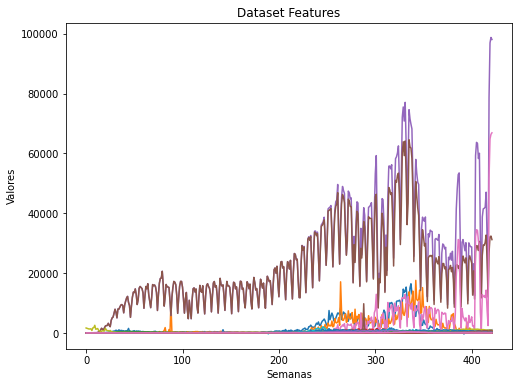

['confirmados_novos', 'recuperados', 'Temperature', 'Visibility', 'total_testes', 'testes_pcr', 'testes_antigenio', 'new_cases_per_million_Austria', 'new_deaths_per_million_Austria', 'new_cases_per_million_Belgium', 'new_deaths_per_million_Belgium', 'icu_patients_per_million_Belgium', 'hosp_patients_per_million_Belgium', 'new_deaths_per_million_Bulgaria', 'new_cases_per_million_Canada', 'new_deaths_per_million_Canada', 'icu_patients_per_million_Canada', 'new_cases_per_million_Cyprus', 'new_deaths_per_million_Czechia', 'hosp_patients_per_million_Czechia', 'new_cases_per_million_Denmark', 'new_tests_per_thousand_Estonia', 'icu_patients_per_million_France', 'new_cases_per_million_Georgia', 'new_cases_per_million_Germany', 'new_deaths_per_million_Germany', 'icu_patients_per_million_Germany', 'new_deaths_per_million_Hungary', 'hosp_patients_per_million_Hungary', 'positive_rate_India', 'new_cases_per_million_Ireland', 'new_deaths_per_million_Ireland', 'icu_patients_per_million_Ireland', 'hos

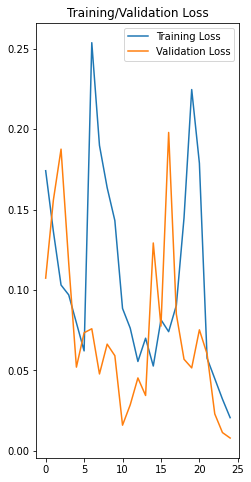

Epoch 1/25
177/177 [==============================] - 1s 5ms/step - loss: 0.0145 - mae: 0.0145 - rmse: 0.0145 - val_loss: 0.0261 - val_mae: 0.0261 - val_rmse: 0.0261
Epoch 2/25
177/177 [==============================] - 1s 5ms/step - loss: 0.0122 - mae: 0.0122 - rmse: 0.0122 - val_loss: 0.0263 - val_mae: 0.0263 - val_rmse: 0.0263
Epoch 3/25
177/177 [==============================] - 1s 5ms/step - loss: 0.0122 - mae: 0.0122 - rmse: 0.0122 - val_loss: 0.0277 - val_mae: 0.0277 - val_rmse: 0.0277
Epoch 4/25
177/177 [==============================] - 1s 5ms/step - loss: 0.0123 - mae: 0.0123 - rmse: 0.0123 - val_loss: 0.0369 - val_mae: 0.0369 - val_rmse: 0.0369
Epoch 5/25
177/177 [==============================] - 1s 4ms/step - loss: 0.0123 - mae: 0.0123 - rmse: 0.0123 - val_loss: 0.0248 - val_mae: 0.0248 - val_rmse: 0.0248
Epoch 6/25
177/177 [==============================] - 1s 5ms/step - loss: 0.0122 - mae: 0.0122 - rmse: 0.0122 - val_loss: 0.0264 - val_mae: 0.0264 - val_rmse: 0.0264
Epoc

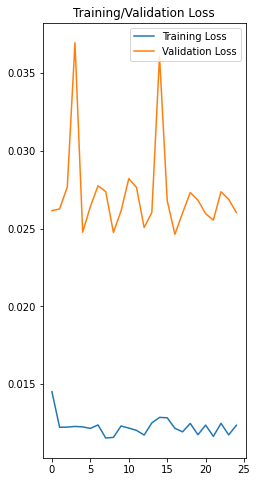

Epoch 1/25
264/264 [==============================] - 1s 4ms/step - loss: 0.0496 - mae: 0.0496 - rmse: 0.0496 - val_loss: 0.2685 - val_mae: 0.2685 - val_rmse: 0.2685
Epoch 2/25
264/264 [==============================] - 1s 4ms/step - loss: 0.0921 - mae: 0.0921 - rmse: 0.0921 - val_loss: 0.2106 - val_mae: 0.2106 - val_rmse: 0.2106
Epoch 3/25
264/264 [==============================] - 1s 4ms/step - loss: 0.1013 - mae: 0.1013 - rmse: 0.1013 - val_loss: 0.2332 - val_mae: 0.2332 - val_rmse: 0.2332
Epoch 4/25
264/264 [==============================] - 1s 4ms/step - loss: 0.1000 - mae: 0.1000 - rmse: 0.1000 - val_loss: 0.2267 - val_mae: 0.2267 - val_rmse: 0.2267
Epoch 5/25
264/264 [==============================] - 1s 4ms/step - loss: 0.0973 - mae: 0.0973 - rmse: 0.0973 - val_loss: 0.1929 - val_mae: 0.1929 - val_rmse: 0.1929
Epoch 6/25
264/264 [==============================] - 1s 4ms/step - loss: 0.0904 - mae: 0.0904 - rmse: 0.0904 - val_loss: 0.1974 - val_mae: 0.1974 - val_rmse: 0.1974
Epoc

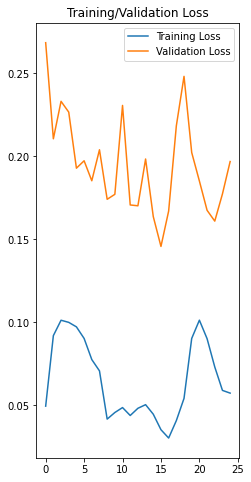

[[-0.93001461 -0.91440929 -0.40909091 ... -0.42119764 -0.32589088
  -0.92739274]
 [-0.94851509 -0.93057136 -0.40151515 ... -0.55036558 -0.36965844
  -0.94059406]
 [-0.9406037  -0.89858866 -0.35606061 ... -0.48499394 -0.48543546
  -0.9669967 ]
 ...
 [-0.94839338 -0.89733667 -0.1969697  ... -0.59435208 -0.62472276
  -0.9669967 ]
 [-0.92575463 -0.93944912 -0.27272727 ... -0.58158401 -0.61718172
  -0.99339934]
 [-0.92259007 -0.94070112 -0.1969697  ... -0.55222957 -0.56986544
  -0.97359736]]
1
Previsão:[[45.48614]]
[45.48614]


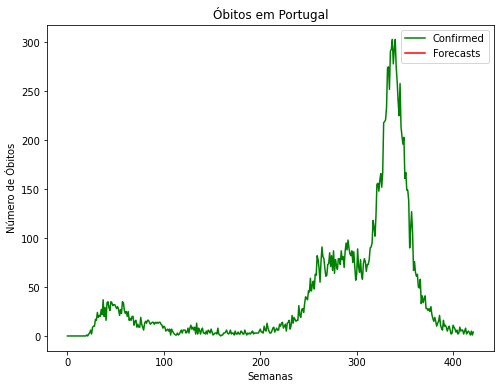

[array([[45.48614]], dtype=float32)]
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/50
45/45 [==============================] - 1s 10ms/step - loss: 0.6401 - mae: 0.6356 - rmse: 0.6401 - val_loss: 0.0624 - val_mae: 0.0596 - val_rmse: 0.0625
Epoch 2/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1085 - mae: 0.0996 - rmse: 0.1085 - val_loss: 0.0684 - val_mae: 0.0597 - val_rmse: 0.0641
Epoch 3/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1146 - mae: 0.1065 - rmse: 0.1146 - val_loss: 0.0657 - val_mae: 0.0568 - val_rmse: 0.0611
Epoch 4/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1056 - mae: 0.0978 - rmse: 0.1056 - val_loss: 0.0785 - val_mae: 0.0686 - val_rmse: 0.0739
Epoch 5/50
45/45 [==============================] - 0s 6ms/step - loss: 0.0986 - mae: 0.0895 - rmse: 0.0986 - val_loss: 0.0814 - val_mae

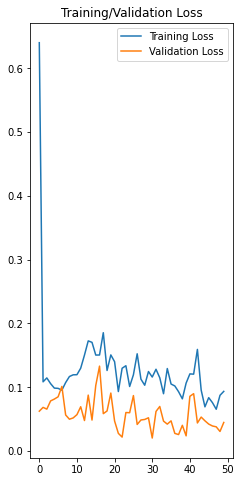

Epoch 1/50
89/89 [==============================] - 1s 5ms/step - loss: 0.0742 - mae: 0.0704 - rmse: 0.0738 - val_loss: 0.1088 - val_mae: 0.1056 - val_rmse: 0.1154
Epoch 2/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0837 - mae: 0.0802 - rmse: 0.0834 - val_loss: 0.0904 - val_mae: 0.0876 - val_rmse: 0.0971
Epoch 3/50
89/89 [==============================] - 0s 5ms/step - loss: 0.0863 - mae: 0.0830 - rmse: 0.0858 - val_loss: 0.1019 - val_mae: 0.0990 - val_rmse: 0.1087
Epoch 4/50
89/89 [==============================] - 0s 5ms/step - loss: 0.0782 - mae: 0.0746 - rmse: 0.0778 - val_loss: 0.0959 - val_mae: 0.0928 - val_rmse: 0.1028
Epoch 5/50
89/89 [==============================] - 0s 6ms/step - loss: 0.0731 - mae: 0.0696 - rmse: 0.0727 - val_loss: 0.0879 - val_mae: 0.0847 - val_rmse: 0.0946
Epoch 6/50
89/89 [==============================] - 0s 5ms/step - loss: 0.0670 - mae: 0.0635 - rmse: 0.0667 - val_loss: 0.0842 - val_mae: 0.0809 - val_rmse: 0.0908
Epoch 7/50
89/89

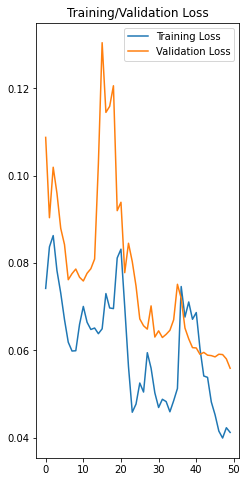

Epoch 1/50
132/132 [==============================] - 1s 4ms/step - loss: 0.0816 - mae: 0.0773 - rmse: 0.0816 - val_loss: 0.3715 - val_mae: 0.3445 - val_rmse: 0.3739
Epoch 2/50
132/132 [==============================] - 1s 4ms/step - loss: 0.1028 - mae: 0.0980 - rmse: 0.1028 - val_loss: 0.5344 - val_mae: 0.5150 - val_rmse: 0.5537
Epoch 3/50
132/132 [==============================] - 0s 4ms/step - loss: 0.1073 - mae: 0.1027 - rmse: 0.1073 - val_loss: 0.4586 - val_mae: 0.4340 - val_rmse: 0.4723
Epoch 4/50
132/132 [==============================] - 1s 4ms/step - loss: 0.0682 - mae: 0.0630 - rmse: 0.0682 - val_loss: 0.4497 - val_mae: 0.4198 - val_rmse: 0.4533
Epoch 5/50
132/132 [==============================] - 1s 4ms/step - loss: 0.0776 - mae: 0.0731 - rmse: 0.0776 - val_loss: 0.4396 - val_mae: 0.4060 - val_rmse: 0.4452
Epoch 6/50
132/132 [==============================] - 1s 4ms/step - loss: 0.0592 - mae: 0.0551 - rmse: 0.0592 - val_loss: 0.4667 - val_mae: 0.4335 - val_rmse: 0.4726
Epoc

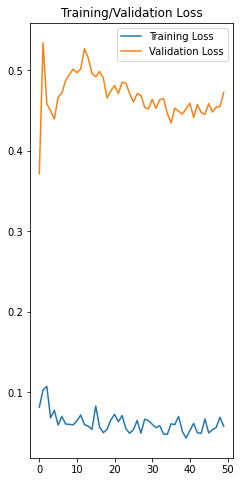

[[-0.93001461 -0.91440929 -0.40909091 ... -0.42119764 -0.32589088
  -0.92739274]
 [-0.94851509 -0.93057136 -0.40151515 ... -0.55036558 -0.36965844
  -0.94059406]
 [-0.9406037  -0.89858866 -0.35606061 ... -0.48499394 -0.48543546
  -0.9669967 ]
 ...
 [-0.94839338 -0.89733667 -0.1969697  ... -0.59435208 -0.62472276
  -0.9669967 ]
 [-0.92575463 -0.93944912 -0.27272727 ... -0.58158401 -0.61718172
  -0.99339934]
 [-0.92259007 -0.94070112 -0.1969697  ... -0.55222957 -0.56986544
  -0.97359736]]
1
Previsão:[[101.332756]]
[101.332756]


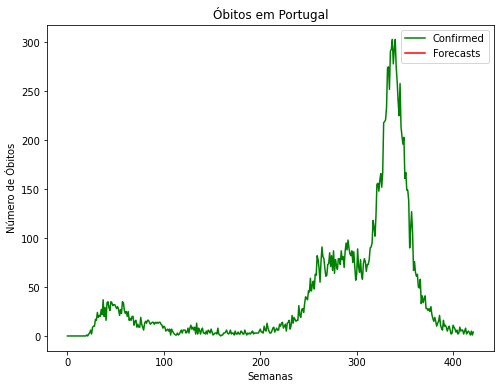

[array([[101.332756]], dtype=float32)]
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/100
30/30 [==============================] - 1s 10ms/step - loss: 0.7773 - mae: 0.7763 - rmse: 0.7773 - val_loss: 0.6611 - val_mae: 0.6607 - val_rmse: 0.6611
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.7047 - mae: 0.7036 - rmse: 0.7047 - val_loss: 0.5784 - val_mae: 0.5779 - val_rmse: 0.5784
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6329 - mae: 0.6318 - rmse: 0.6329 - val_loss: 0.4956 - val_mae: 0.4951 - val_rmse: 0.4956
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5616 - mae: 0.5603 - rmse: 0.5616 - val_loss: 0.4131 - val_mae: 0.4125 - val_rmse: 0.4131
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4902 - mae: 0.4888 - rmse: 0.4902 - val_loss: 0.3304 - 

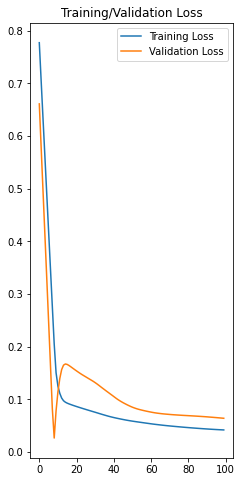

Epoch 1/100
59/59 [==============================] - 0s 5ms/step - loss: 0.0700 - mae: 0.0645 - rmse: 0.0700 - val_loss: 0.0491 - val_mae: 0.0436 - val_rmse: 0.0473
Epoch 2/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0848 - mae: 0.0798 - rmse: 0.0848 - val_loss: 0.0474 - val_mae: 0.0408 - val_rmse: 0.0453
Epoch 3/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0805 - mae: 0.0755 - rmse: 0.0805 - val_loss: 0.0470 - val_mae: 0.0401 - val_rmse: 0.0447
Epoch 4/100
59/59 [==============================] - 0s 5ms/step - loss: 0.0763 - mae: 0.0714 - rmse: 0.0763 - val_loss: 0.0465 - val_mae: 0.0392 - val_rmse: 0.0441
Epoch 5/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0728 - mae: 0.0683 - rmse: 0.0728 - val_loss: 0.0460 - val_mae: 0.0385 - val_rmse: 0.0433
Epoch 6/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0701 - mae: 0.0660 - rmse: 0.0701 - val_loss: 0.0457 - val_mae: 0.0384 - val_rmse: 0.0427
Epoch 7/10

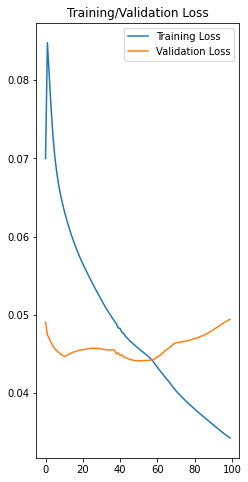

Epoch 1/100
88/88 [==============================] - 0s 5ms/step - loss: 0.1004 - mae: 0.0915 - rmse: 0.1004 - val_loss: 0.4845 - val_mae: 0.4460 - val_rmse: 0.5159
Epoch 2/100
88/88 [==============================] - 0s 4ms/step - loss: 0.0925 - mae: 0.0834 - rmse: 0.0925 - val_loss: 0.4608 - val_mae: 0.4184 - val_rmse: 0.4938
Epoch 3/100
88/88 [==============================] - 0s 4ms/step - loss: 0.0872 - mae: 0.0780 - rmse: 0.0872 - val_loss: 0.4490 - val_mae: 0.4047 - val_rmse: 0.4834
Epoch 4/100
88/88 [==============================] - 0s 4ms/step - loss: 0.0832 - mae: 0.0738 - rmse: 0.0832 - val_loss: 0.4440 - val_mae: 0.3989 - val_rmse: 0.4794
Epoch 5/100
88/88 [==============================] - 0s 4ms/step - loss: 0.0798 - mae: 0.0706 - rmse: 0.0798 - val_loss: 0.4422 - val_mae: 0.3967 - val_rmse: 0.4783
Epoch 6/100
88/88 [==============================] - 0s 4ms/step - loss: 0.0770 - mae: 0.0680 - rmse: 0.0770 - val_loss: 0.4427 - val_mae: 0.3977 - val_rmse: 0.4793
Epoch 7/10

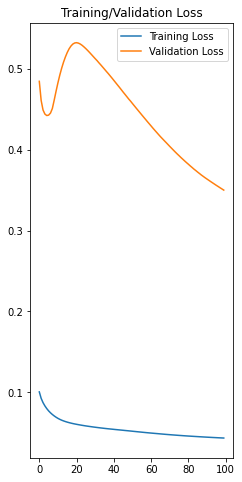

[[-0.93001461 -0.91440929 -0.40909091 ... -0.42119764 -0.32589088
  -0.92739274]
 [-0.94851509 -0.93057136 -0.40151515 ... -0.55036558 -0.36965844
  -0.94059406]
 [-0.9406037  -0.89858866 -0.35606061 ... -0.48499394 -0.48543546
  -0.9669967 ]
 ...
 [-0.94839338 -0.89733667 -0.1969697  ... -0.59435208 -0.62472276
  -0.9669967 ]
 [-0.92575463 -0.93944912 -0.27272727 ... -0.58158401 -0.61718172
  -0.99339934]
 [-0.92259007 -0.94070112 -0.1969697  ... -0.55222957 -0.56986544
  -0.97359736]]
1
Previsão:[[130.90848]]
[130.90848]


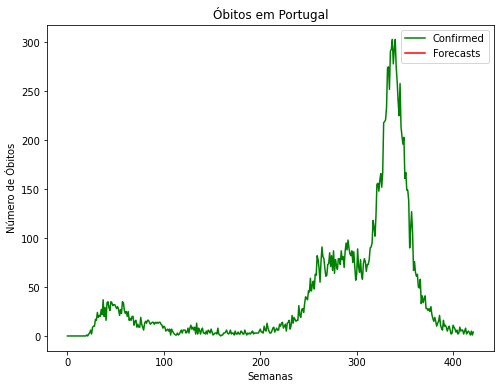

[array([[130.90848]], dtype=float32)]
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/60
90/90 [==============================] - 1s 6ms/step - loss: 0.1578 - mae: 0.1578 - rmse: 0.1578 - val_loss: 0.0270 - val_mae: 0.0270 - val_rmse: 0.0270
Epoch 2/60
90/90 [==============================] - 0s 4ms/step - loss: 0.1195 - mae: 0.1195 - rmse: 0.1195 - val_loss: 0.0557 - val_mae: 0.0557 - val_rmse: 0.0557
Epoch 3/60
90/90 [==============================] - 0s 4ms/step - loss: 0.0908 - mae: 0.0908 - rmse: 0.0908 - val_loss: 0.0538 - val_mae: 0.0538 - val_rmse: 0.0538
Epoch 4/60
90/90 [==============================] - 0s 4ms/step - loss: 0.1419 - mae: 0.1419 - rmse: 0.1419 - val_loss: 0.0678 - val_mae: 0.0678 - val_rmse: 0.0678
Epoch 5/60
90/90 [==============================] - 0s 4ms/step - loss: 0.1853 - mae: 0.1853 - rmse: 0.1853 - val_loss: 0.0805 - val_mae

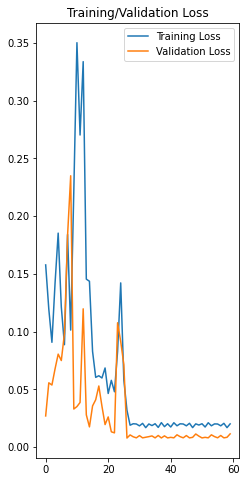

Epoch 1/60
177/177 [==============================] - 1s 4ms/step - loss: 0.0149 - mae: 0.0149 - rmse: 0.0149 - val_loss: 0.0313 - val_mae: 0.0313 - val_rmse: 0.0313
Epoch 2/60
177/177 [==============================] - 1s 4ms/step - loss: 0.0124 - mae: 0.0124 - rmse: 0.0124 - val_loss: 0.0256 - val_mae: 0.0256 - val_rmse: 0.0256
Epoch 3/60
177/177 [==============================] - 1s 4ms/step - loss: 0.0122 - mae: 0.0122 - rmse: 0.0122 - val_loss: 0.0272 - val_mae: 0.0272 - val_rmse: 0.0272
Epoch 4/60
177/177 [==============================] - 1s 4ms/step - loss: 0.0124 - mae: 0.0124 - rmse: 0.0124 - val_loss: 0.0286 - val_mae: 0.0286 - val_rmse: 0.0286
Epoch 5/60
177/177 [==============================] - 1s 4ms/step - loss: 0.0125 - mae: 0.0125 - rmse: 0.0125 - val_loss: 0.0296 - val_mae: 0.0296 - val_rmse: 0.0296
Epoch 6/60
177/177 [==============================] - 1s 4ms/step - loss: 0.0126 - mae: 0.0126 - rmse: 0.0126 - val_loss: 0.0302 - val_mae: 0.0302 - val_rmse: 0.0302
Epoc

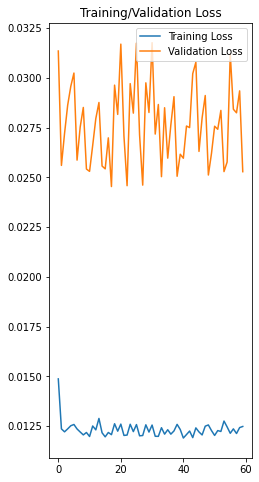

Epoch 1/60
264/264 [==============================] - 1s 4ms/step - loss: 0.0597 - mae: 0.0597 - rmse: 0.0597 - val_loss: 0.2029 - val_mae: 0.2029 - val_rmse: 0.2029
Epoch 2/60
264/264 [==============================] - 1s 4ms/step - loss: 0.0909 - mae: 0.0909 - rmse: 0.0909 - val_loss: 0.2595 - val_mae: 0.2595 - val_rmse: 0.2595
Epoch 3/60
264/264 [==============================] - 1s 4ms/step - loss: 0.1094 - mae: 0.1094 - rmse: 0.1094 - val_loss: 0.4118 - val_mae: 0.4118 - val_rmse: 0.4118
Epoch 4/60
264/264 [==============================] - 1s 4ms/step - loss: 0.0957 - mae: 0.0957 - rmse: 0.0957 - val_loss: 0.2981 - val_mae: 0.2981 - val_rmse: 0.2981
Epoch 5/60
264/264 [==============================] - 1s 4ms/step - loss: 0.1160 - mae: 0.1160 - rmse: 0.1160 - val_loss: 0.2177 - val_mae: 0.2177 - val_rmse: 0.2177
Epoch 6/60
264/264 [==============================] - 1s 4ms/step - loss: 0.1308 - mae: 0.1308 - rmse: 0.1308 - val_loss: 0.2695 - val_mae: 0.2695 - val_rmse: 0.2695
Epoc

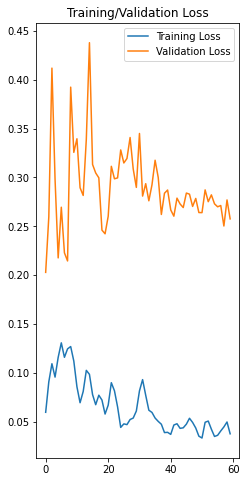

[[-0.93001461 -0.91440929 -0.40909091 ... -0.42119764 -0.32589088
  -0.92739274]
 [-0.94851509 -0.93057136 -0.40151515 ... -0.55036558 -0.36965844
  -0.94059406]
 [-0.9406037  -0.89858866 -0.35606061 ... -0.48499394 -0.48543546
  -0.9669967 ]
 ...
 [-0.94839338 -0.89733667 -0.1969697  ... -0.59435208 -0.62472276
  -0.9669967 ]
 [-0.92575463 -0.93944912 -0.27272727 ... -0.58158401 -0.61718172
  -0.99339934]
 [-0.92259007 -0.94070112 -0.1969697  ... -0.55222957 -0.56986544
  -0.97359736]]
1
Previsão:[[52.389458]]
[52.389458]


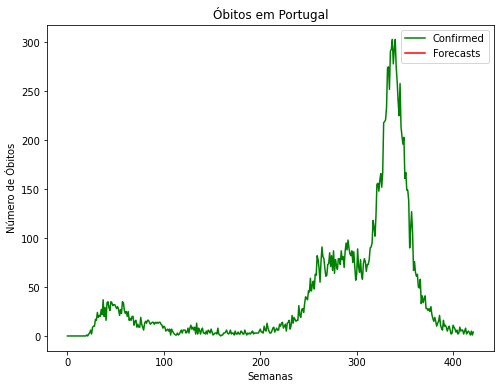

[array([[52.389458]], dtype=float32)]
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/90
45/45 [==============================] - 1s 8ms/step - loss: 0.3694 - mae: 0.3641 - rmse: 0.3694 - val_loss: 0.1461 - val_mae: 0.1405 - val_rmse: 0.1489
Epoch 2/90
45/45 [==============================] - 0s 4ms/step - loss: 0.3264 - mae: 0.3202 - rmse: 0.3264 - val_loss: 0.1272 - val_mae: 0.1205 - val_rmse: 0.1296
Epoch 3/90
45/45 [==============================] - 0s 4ms/step - loss: 0.3010 - mae: 0.2952 - rmse: 0.3010 - val_loss: 0.0742 - val_mae: 0.0635 - val_rmse: 0.0757
Epoch 4/90
45/45 [==============================] - 0s 4ms/step - loss: 0.2434 - mae: 0.2350 - rmse: 0.2434 - val_loss: 0.0855 - val_mae: 0.0754 - val_rmse: 0.0868
Epoch 5/90
45/45 [==============================] - 0s 4ms/step - loss: 0.2161 - mae: 0.2070 - rmse: 0.2161 - val_loss: 0.0822 - val_mae

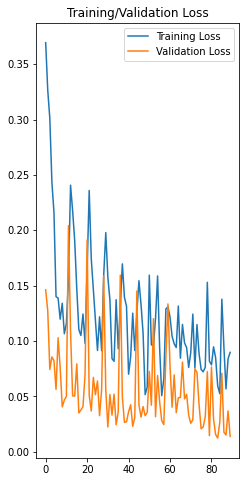

Epoch 1/90
89/89 [==============================] - 1s 5ms/step - loss: 0.0624 - mae: 0.0601 - rmse: 0.0623 - val_loss: 0.0332 - val_mae: 0.0315 - val_rmse: 0.0323
Epoch 2/90
89/89 [==============================] - 0s 5ms/step - loss: 0.0393 - mae: 0.0367 - rmse: 0.0393 - val_loss: 0.0319 - val_mae: 0.0302 - val_rmse: 0.0316
Epoch 3/90
89/89 [==============================] - 0s 5ms/step - loss: 0.0401 - mae: 0.0374 - rmse: 0.0402 - val_loss: 0.0306 - val_mae: 0.0288 - val_rmse: 0.0310
Epoch 4/90
89/89 [==============================] - 0s 5ms/step - loss: 0.0603 - mae: 0.0575 - rmse: 0.0600 - val_loss: 0.0419 - val_mae: 0.0404 - val_rmse: 0.0411
Epoch 5/90
89/89 [==============================] - 0s 5ms/step - loss: 0.0558 - mae: 0.0533 - rmse: 0.0556 - val_loss: 0.0372 - val_mae: 0.0357 - val_rmse: 0.0374
Epoch 6/90
89/89 [==============================] - 0s 5ms/step - loss: 0.0533 - mae: 0.0514 - rmse: 0.0532 - val_loss: 0.0326 - val_mae: 0.0301 - val_rmse: 0.0336
Epoch 7/90
89/89

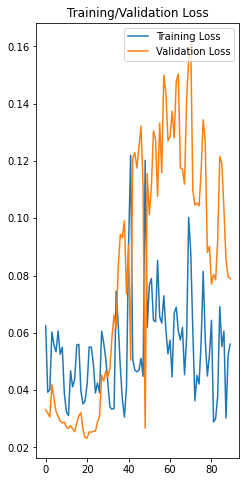

Epoch 1/90
132/132 [==============================] - 1s 4ms/step - loss: 0.1227 - mae: 0.1203 - rmse: 0.1227 - val_loss: 0.5103 - val_mae: 0.4950 - val_rmse: 0.5096
Epoch 2/90
132/132 [==============================] - 1s 4ms/step - loss: 0.0993 - mae: 0.0956 - rmse: 0.0993 - val_loss: 0.3980 - val_mae: 0.3864 - val_rmse: 0.4074
Epoch 3/90
132/132 [==============================] - 1s 4ms/step - loss: 0.0929 - mae: 0.0897 - rmse: 0.0929 - val_loss: 0.3743 - val_mae: 0.3606 - val_rmse: 0.3870
Epoch 4/90
132/132 [==============================] - 1s 4ms/step - loss: 0.0656 - mae: 0.0621 - rmse: 0.0656 - val_loss: 0.3511 - val_mae: 0.3363 - val_rmse: 0.3675
Epoch 5/90
132/132 [==============================] - 1s 4ms/step - loss: 0.0479 - mae: 0.0449 - rmse: 0.0479 - val_loss: 0.3751 - val_mae: 0.3585 - val_rmse: 0.3986
Epoch 6/90
132/132 [==============================] - 1s 4ms/step - loss: 0.0503 - mae: 0.0470 - rmse: 0.0503 - val_loss: 0.3827 - val_mae: 0.3669 - val_rmse: 0.4066
Epoc

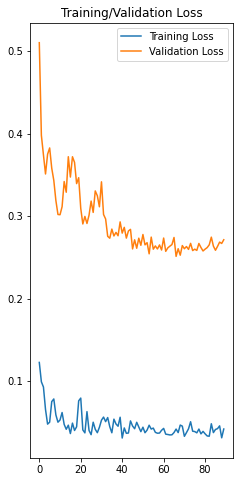

[[-0.93001461 -0.91440929 -0.40909091 ... -0.42119764 -0.32589088
  -0.92739274]
 [-0.94851509 -0.93057136 -0.40151515 ... -0.55036558 -0.36965844
  -0.94059406]
 [-0.9406037  -0.89858866 -0.35606061 ... -0.48499394 -0.48543546
  -0.9669967 ]
 ...
 [-0.94839338 -0.89733667 -0.1969697  ... -0.59435208 -0.62472276
  -0.9669967 ]
 [-0.92575463 -0.93944912 -0.27272727 ... -0.58158401 -0.61718172
  -0.99339934]
 [-0.92259007 -0.94070112 -0.1969697  ... -0.55222957 -0.56986544
  -0.97359736]]
1
Previsão:[[115.966484]]
[115.966484]


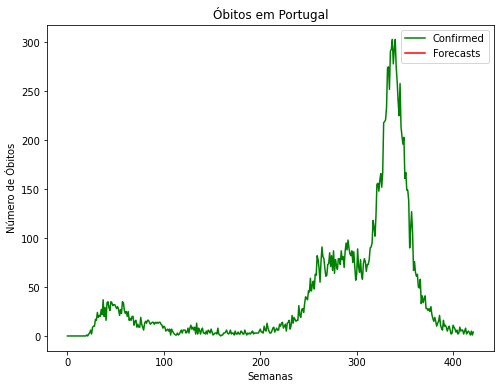

[array([[115.966484]], dtype=float32)]
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/120
30/30 [==============================] - 1s 10ms/step - loss: 1.9759 - mae: 1.9749 - rmse: 1.9759 - val_loss: 1.9562 - val_mae: 1.9560 - val_rmse: 1.9562
Epoch 2/120
30/30 [==============================] - 0s 5ms/step - loss: 1.8456 - mae: 1.8446 - rmse: 1.8456 - val_loss: 1.8170 - val_mae: 1.8168 - val_rmse: 1.8170
Epoch 3/120
30/30 [==============================] - 0s 4ms/step - loss: 1.7124 - mae: 1.7114 - rmse: 1.7124 - val_loss: 1.6749 - val_mae: 1.6747 - val_rmse: 1.6749
Epoch 4/120
30/30 [==============================] - 0s 4ms/step - loss: 1.5764 - mae: 1.5753 - rmse: 1.5764 - val_loss: 1.5300 - val_mae: 1.5298 - val_rmse: 1.5300
Epoch 5/120
30/30 [==============================] - 0s 5ms/step - loss: 1.4375 - mae: 1.4363 - rmse: 1.4375 - val_loss: 1.3821 - 

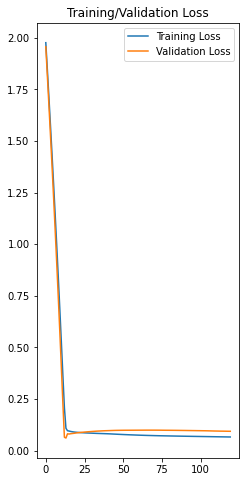

Epoch 1/120
59/59 [==============================] - 0s 5ms/step - loss: 0.0942 - mae: 0.0838 - rmse: 0.0942 - val_loss: 0.1069 - val_mae: 0.0983 - val_rmse: 0.1130
Epoch 2/120
59/59 [==============================] - 0s 4ms/step - loss: 0.1096 - mae: 0.1012 - rmse: 0.1096 - val_loss: 0.0999 - val_mae: 0.0914 - val_rmse: 0.1060
Epoch 3/120
59/59 [==============================] - 0s 4ms/step - loss: 0.1015 - mae: 0.0930 - rmse: 0.1015 - val_loss: 0.1010 - val_mae: 0.0923 - val_rmse: 0.1072
Epoch 4/120
59/59 [==============================] - 0s 4ms/step - loss: 0.0993 - mae: 0.0902 - rmse: 0.0993 - val_loss: 0.0977 - val_mae: 0.0891 - val_rmse: 0.1037
Epoch 5/120
59/59 [==============================] - 0s 4ms/step - loss: 0.0951 - mae: 0.0854 - rmse: 0.0951 - val_loss: 0.0988 - val_mae: 0.0900 - val_rmse: 0.1048
Epoch 6/120
59/59 [==============================] - 0s 4ms/step - loss: 0.0928 - mae: 0.0830 - rmse: 0.0928 - val_loss: 0.0993 - val_mae: 0.0904 - val_rmse: 0.1050
Epoch 7/12

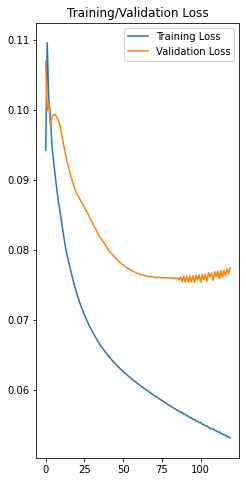

Epoch 1/120
88/88 [==============================] - 0s 4ms/step - loss: 0.0919 - mae: 0.0779 - rmse: 0.0919 - val_loss: 0.3734 - val_mae: 0.3380 - val_rmse: 0.3791
Epoch 2/120
88/88 [==============================] - 0s 4ms/step - loss: 0.0912 - mae: 0.0771 - rmse: 0.0912 - val_loss: 0.3692 - val_mae: 0.3346 - val_rmse: 0.3748
Epoch 3/120
88/88 [==============================] - 0s 4ms/step - loss: 0.0898 - mae: 0.0758 - rmse: 0.0898 - val_loss: 0.3655 - val_mae: 0.3314 - val_rmse: 0.3710
Epoch 4/120
88/88 [==============================] - 0s 4ms/step - loss: 0.0887 - mae: 0.0746 - rmse: 0.0887 - val_loss: 0.3624 - val_mae: 0.3285 - val_rmse: 0.3678
Epoch 5/120
88/88 [==============================] - 0s 4ms/step - loss: 0.0877 - mae: 0.0735 - rmse: 0.0877 - val_loss: 0.3597 - val_mae: 0.3259 - val_rmse: 0.3650
Epoch 6/120
88/88 [==============================] - 0s 4ms/step - loss: 0.0868 - mae: 0.0726 - rmse: 0.0868 - val_loss: 0.3574 - val_mae: 0.3236 - val_rmse: 0.3627
Epoch 7/12

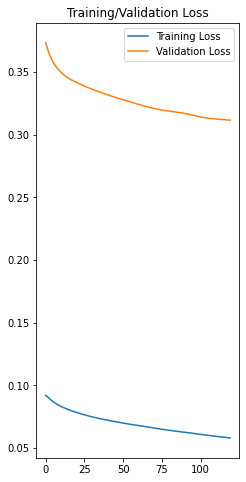

[[-0.93001461 -0.91440929 -0.40909091 ... -0.42119764 -0.32589088
  -0.92739274]
 [-0.94851509 -0.93057136 -0.40151515 ... -0.55036558 -0.36965844
  -0.94059406]
 [-0.9406037  -0.89858866 -0.35606061 ... -0.48499394 -0.48543546
  -0.9669967 ]
 ...
 [-0.94839338 -0.89733667 -0.1969697  ... -0.59435208 -0.62472276
  -0.9669967 ]
 [-0.92575463 -0.93944912 -0.27272727 ... -0.58158401 -0.61718172
  -0.99339934]
 [-0.92259007 -0.94070112 -0.1969697  ... -0.55222957 -0.56986544
  -0.97359736]]
1
Previsão:[[53.849983]]
[53.849983]


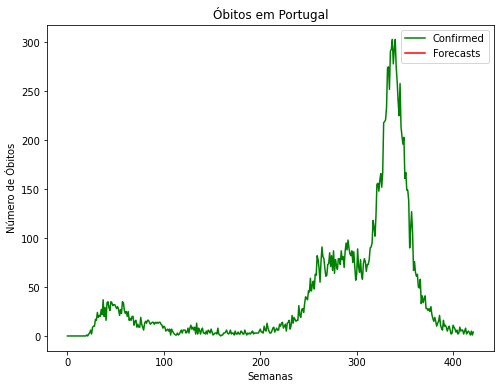

[array([[53.849983]], dtype=float32)]
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/50
90/90 [==============================] - 1s 6ms/step - loss: 0.2312 - mae: 0.2312 - rmse: 0.2312 - val_loss: 0.1439 - val_mae: 0.1439 - val_rmse: 0.1439
Epoch 2/50
90/90 [==============================] - 0s 4ms/step - loss: 0.1130 - mae: 0.1130 - rmse: 0.1130 - val_loss: 0.2002 - val_mae: 0.2002 - val_rmse: 0.2002
Epoch 3/50
90/90 [==============================] - 0s 4ms/step - loss: 0.1404 - mae: 0.1404 - rmse: 0.1404 - val_loss: 0.0468 - val_mae: 0.0468 - val_rmse: 0.0468
Epoch 4/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0900 - mae: 0.0900 - rmse: 0.0900 - val_loss: 0.0576 - val_mae: 0.0576 - val_rmse: 0.0576
Epoch 5/50
90/90 [==============================] - 0s 4ms/step - loss: 0.1020 - mae: 0.1020 - rmse: 0.1020 - val_loss: 0.0672 - val_mae

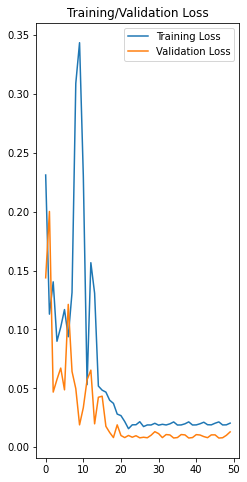

Epoch 1/50
177/177 [==============================] - 1s 4ms/step - loss: 0.0147 - mae: 0.0147 - rmse: 0.0147 - val_loss: 0.0424 - val_mae: 0.0424 - val_rmse: 0.0424
Epoch 2/50
177/177 [==============================] - 1s 4ms/step - loss: 0.0122 - mae: 0.0122 - rmse: 0.0122 - val_loss: 0.0369 - val_mae: 0.0369 - val_rmse: 0.0369
Epoch 3/50
177/177 [==============================] - 1s 4ms/step - loss: 0.0125 - mae: 0.0125 - rmse: 0.0125 - val_loss: 0.0413 - val_mae: 0.0413 - val_rmse: 0.0413
Epoch 4/50
177/177 [==============================] - 1s 4ms/step - loss: 0.0127 - mae: 0.0127 - rmse: 0.0127 - val_loss: 0.0255 - val_mae: 0.0255 - val_rmse: 0.0255
Epoch 5/50
177/177 [==============================] - 1s 4ms/step - loss: 0.0118 - mae: 0.0118 - rmse: 0.0118 - val_loss: 0.0255 - val_mae: 0.0255 - val_rmse: 0.0255
Epoch 6/50
177/177 [==============================] - 1s 4ms/step - loss: 0.0125 - mae: 0.0125 - rmse: 0.0125 - val_loss: 0.0265 - val_mae: 0.0265 - val_rmse: 0.0265
Epoc

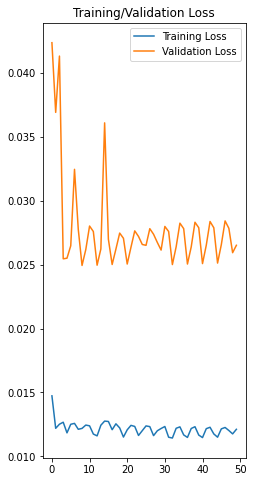

Epoch 1/50
264/264 [==============================] - 1s 4ms/step - loss: 0.0598 - mae: 0.0598 - rmse: 0.0598 - val_loss: 0.2314 - val_mae: 0.2314 - val_rmse: 0.2314
Epoch 2/50
264/264 [==============================] - 1s 4ms/step - loss: 0.0718 - mae: 0.0718 - rmse: 0.0718 - val_loss: 0.8406 - val_mae: 0.8406 - val_rmse: 0.8406
Epoch 3/50
264/264 [==============================] - 1s 3ms/step - loss: 0.0848 - mae: 0.0848 - rmse: 0.0848 - val_loss: 0.5871 - val_mae: 0.5871 - val_rmse: 0.5871
Epoch 4/50
264/264 [==============================] - 1s 4ms/step - loss: 0.0569 - mae: 0.0569 - rmse: 0.0569 - val_loss: 0.4812 - val_mae: 0.4812 - val_rmse: 0.4812
Epoch 5/50
264/264 [==============================] - 1s 3ms/step - loss: 0.0715 - mae: 0.0715 - rmse: 0.0715 - val_loss: 0.5706 - val_mae: 0.5706 - val_rmse: 0.5706
Epoch 6/50
264/264 [==============================] - 1s 4ms/step - loss: 0.0521 - mae: 0.0521 - rmse: 0.0521 - val_loss: 0.4497 - val_mae: 0.4497 - val_rmse: 0.4497
Epoc

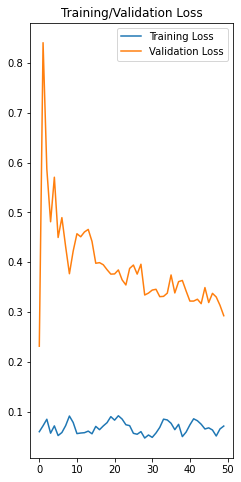

[[-0.93001461 -0.91440929 -0.40909091 ... -0.42119764 -0.32589088
  -0.92739274]
 [-0.94851509 -0.93057136 -0.40151515 ... -0.55036558 -0.36965844
  -0.94059406]
 [-0.9406037  -0.89858866 -0.35606061 ... -0.48499394 -0.48543546
  -0.9669967 ]
 ...
 [-0.94839338 -0.89733667 -0.1969697  ... -0.59435208 -0.62472276
  -0.9669967 ]
 [-0.92575463 -0.93944912 -0.27272727 ... -0.58158401 -0.61718172
  -0.99339934]
 [-0.92259007 -0.94070112 -0.1969697  ... -0.55222957 -0.56986544
  -0.97359736]]
1
Previsão:[[44.37682]]
[44.37682]


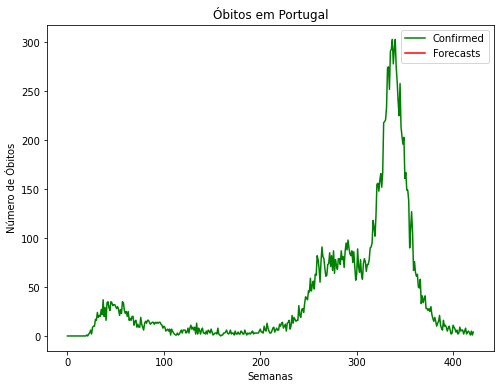

[array([[44.37682]], dtype=float32)]
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/90
45/45 [==============================] - 1s 8ms/step - loss: 1.8778 - mae: 1.8770 - rmse: 1.8778 - val_loss: 1.3591 - val_mae: 1.3589 - val_rmse: 1.3610
Epoch 2/90
45/45 [==============================] - 0s 4ms/step - loss: 0.5250 - mae: 0.5215 - rmse: 0.5250 - val_loss: 0.1292 - val_mae: 0.1273 - val_rmse: 0.1312
Epoch 3/90
45/45 [==============================] - 0s 4ms/step - loss: 0.3505 - mae: 0.3456 - rmse: 0.3505 - val_loss: 0.1961 - val_mae: 0.1952 - val_rmse: 0.1973
Epoch 4/90
45/45 [==============================] - 0s 4ms/step - loss: 0.2264 - mae: 0.2205 - rmse: 0.2264 - val_loss: 0.0791 - val_mae: 0.0746 - val_rmse: 0.0789
Epoch 5/90
45/45 [==============================] - 0s 4ms/step - loss: 0.1539 - mae: 0.1469 - rmse: 0.1539 - val_loss: 0.0840 - val_mae:

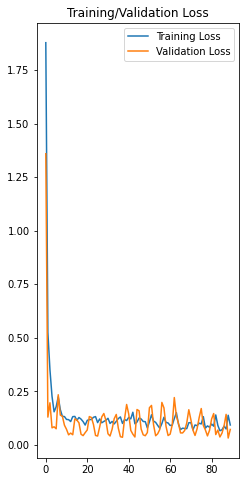

Epoch 1/90
89/89 [==============================] - 1s 5ms/step - loss: 0.0553 - mae: 0.0516 - rmse: 0.0550 - val_loss: 0.1256 - val_mae: 0.1127 - val_rmse: 0.1247
Epoch 2/90
89/89 [==============================] - 0s 5ms/step - loss: 0.0608 - mae: 0.0563 - rmse: 0.0607 - val_loss: 0.1164 - val_mae: 0.1052 - val_rmse: 0.1155
Epoch 3/90
89/89 [==============================] - 0s 5ms/step - loss: 0.0792 - mae: 0.0755 - rmse: 0.0790 - val_loss: 0.1124 - val_mae: 0.1018 - val_rmse: 0.1111
Epoch 4/90
89/89 [==============================] - 0s 5ms/step - loss: 0.0676 - mae: 0.0641 - rmse: 0.0672 - val_loss: 0.1219 - val_mae: 0.1104 - val_rmse: 0.1201
Epoch 5/90
89/89 [==============================] - 0s 5ms/step - loss: 0.0669 - mae: 0.0632 - rmse: 0.0666 - val_loss: 0.1192 - val_mae: 0.1076 - val_rmse: 0.1170
Epoch 6/90
89/89 [==============================] - 0s 5ms/step - loss: 0.0745 - mae: 0.0712 - rmse: 0.0741 - val_loss: 0.1083 - val_mae: 0.0995 - val_rmse: 0.1069
Epoch 7/90
89/89

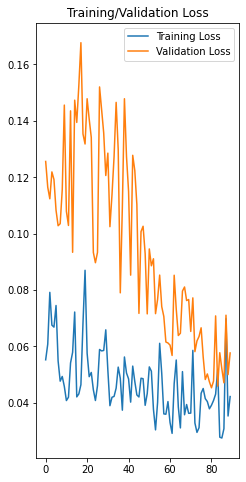

Epoch 1/90
132/132 [==============================] - 1s 4ms/step - loss: 0.0686 - mae: 0.0647 - rmse: 0.0686 - val_loss: 0.3301 - val_mae: 0.3039 - val_rmse: 0.3325
Epoch 2/90
132/132 [==============================] - 0s 4ms/step - loss: 0.0762 - mae: 0.0707 - rmse: 0.0762 - val_loss: 0.3199 - val_mae: 0.2925 - val_rmse: 0.3135
Epoch 3/90
132/132 [==============================] - 1s 4ms/step - loss: 0.0689 - mae: 0.0645 - rmse: 0.0689 - val_loss: 0.3069 - val_mae: 0.2728 - val_rmse: 0.3029
Epoch 4/90
132/132 [==============================] - 1s 4ms/step - loss: 0.0869 - mae: 0.0830 - rmse: 0.0869 - val_loss: 0.3176 - val_mae: 0.2916 - val_rmse: 0.3198
Epoch 5/90
132/132 [==============================] - 0s 4ms/step - loss: 0.0758 - mae: 0.0706 - rmse: 0.0758 - val_loss: 0.2970 - val_mae: 0.2667 - val_rmse: 0.2921
Epoch 6/90
132/132 [==============================] - 1s 4ms/step - loss: 0.0802 - mae: 0.0765 - rmse: 0.0802 - val_loss: 0.2860 - val_mae: 0.2531 - val_rmse: 0.2823
Epoc

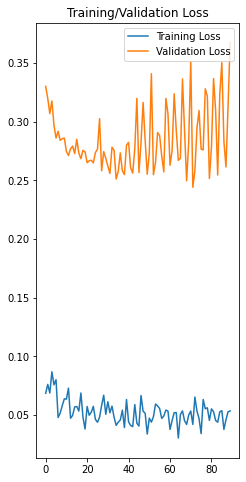

[[-0.93001461 -0.91440929 -0.40909091 ... -0.42119764 -0.32589088
  -0.92739274]
 [-0.94851509 -0.93057136 -0.40151515 ... -0.55036558 -0.36965844
  -0.94059406]
 [-0.9406037  -0.89858866 -0.35606061 ... -0.48499394 -0.48543546
  -0.9669967 ]
 ...
 [-0.94839338 -0.89733667 -0.1969697  ... -0.59435208 -0.62472276
  -0.9669967 ]
 [-0.92575463 -0.93944912 -0.27272727 ... -0.58158401 -0.61718172
  -0.99339934]
 [-0.92259007 -0.94070112 -0.1969697  ... -0.55222957 -0.56986544
  -0.97359736]]
1
Previsão:[[55.67415]]
[55.67415]


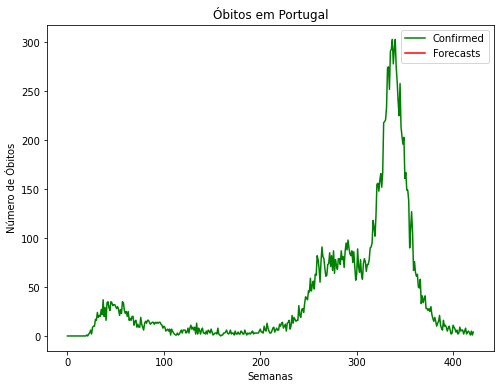

[array([[55.67415]], dtype=float32)]
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/120
30/30 [==============================] - 1s 11ms/step - loss: 0.5053 - mae: 0.5008 - rmse: 0.5053 - val_loss: 0.2050 - val_mae: 0.2026 - val_rmse: 0.2050
Epoch 2/120
30/30 [==============================] - 0s 5ms/step - loss: 0.3357 - mae: 0.3282 - rmse: 0.3357 - val_loss: 0.0392 - val_mae: 0.0296 - val_rmse: 0.0392
Epoch 3/120
30/30 [==============================] - 0s 4ms/step - loss: 0.2090 - mae: 0.2003 - rmse: 0.2090 - val_loss: 0.1428 - val_mae: 0.1387 - val_rmse: 0.1428
Epoch 4/120
30/30 [==============================] - 0s 5ms/step - loss: 0.1587 - mae: 0.1485 - rmse: 0.1587 - val_loss: 0.1974 - val_mae: 0.1946 - val_rmse: 0.1974
Epoch 5/120
30/30 [==============================] - 0s 4ms/step - loss: 0.1464 - mae: 0.1364 - rmse: 0.1464 - val_loss: 0.2142 - va

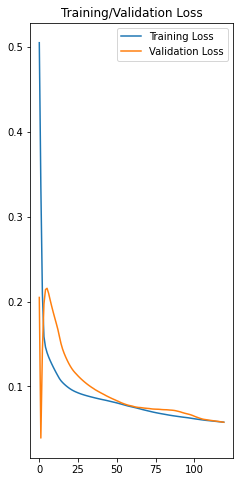

Epoch 1/120
59/59 [==============================] - 0s 5ms/step - loss: 0.0961 - mae: 0.0880 - rmse: 0.0961 - val_loss: 0.2015 - val_mae: 0.1832 - val_rmse: 0.1982
Epoch 2/120
59/59 [==============================] - 0s 4ms/step - loss: 0.1586 - mae: 0.1515 - rmse: 0.1586 - val_loss: 0.2715 - val_mae: 0.2592 - val_rmse: 0.2687
Epoch 3/120
59/59 [==============================] - 0s 4ms/step - loss: 0.1155 - mae: 0.1091 - rmse: 0.1155 - val_loss: 0.2568 - val_mae: 0.2435 - val_rmse: 0.2542
Epoch 4/120
59/59 [==============================] - 0s 4ms/step - loss: 0.1153 - mae: 0.1086 - rmse: 0.1153 - val_loss: 0.2761 - val_mae: 0.2640 - val_rmse: 0.2736
Epoch 5/120
59/59 [==============================] - 0s 4ms/step - loss: 0.1093 - mae: 0.1023 - rmse: 0.1093 - val_loss: 0.2776 - val_mae: 0.2657 - val_rmse: 0.2750
Epoch 6/120
59/59 [==============================] - 0s 4ms/step - loss: 0.1053 - mae: 0.0979 - rmse: 0.1053 - val_loss: 0.2739 - val_mae: 0.2620 - val_rmse: 0.2712
Epoch 7/12

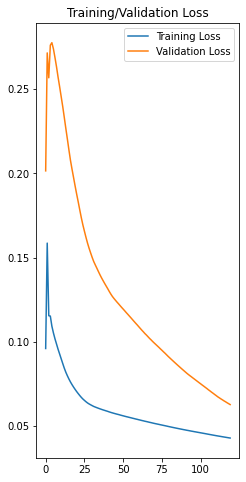

Epoch 1/120
88/88 [==============================] - 0s 4ms/step - loss: 0.1157 - mae: 0.1044 - rmse: 0.1157 - val_loss: 0.5163 - val_mae: 0.4696 - val_rmse: 0.5057
Epoch 2/120
88/88 [==============================] - ETA: 0s - loss: 0.1144 - mae: 0.1032 - rmse: 0.11 - 0s 4ms/step - loss: 0.1144 - mae: 0.1032 - rmse: 0.1144 - val_loss: 0.4810 - val_mae: 0.4344 - val_rmse: 0.4734
Epoch 3/120
88/88 [==============================] - 0s 4ms/step - loss: 0.1107 - mae: 0.0999 - rmse: 0.1107 - val_loss: 0.4578 - val_mae: 0.4137 - val_rmse: 0.4521
Epoch 4/120
88/88 [==============================] - 0s 5ms/step - loss: 0.1088 - mae: 0.0978 - rmse: 0.1088 - val_loss: 0.4393 - val_mae: 0.3982 - val_rmse: 0.4350
Epoch 5/120
88/88 [==============================] - 0s 4ms/step - loss: 0.1070 - mae: 0.0959 - rmse: 0.1070 - val_loss: 0.4234 - val_mae: 0.3845 - val_rmse: 0.4204
Epoch 6/120
88/88 [==============================] - 0s 4ms/step - loss: 0.1051 - mae: 0.0938 - rmse: 0.1051 - val_loss: 0.

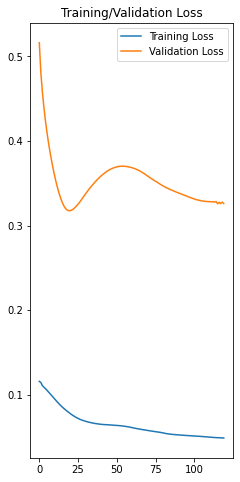

[[-0.93001461 -0.91440929 -0.40909091 ... -0.42119764 -0.32589088
  -0.92739274]
 [-0.94851509 -0.93057136 -0.40151515 ... -0.55036558 -0.36965844
  -0.94059406]
 [-0.9406037  -0.89858866 -0.35606061 ... -0.48499394 -0.48543546
  -0.9669967 ]
 ...
 [-0.94839338 -0.89733667 -0.1969697  ... -0.59435208 -0.62472276
  -0.9669967 ]
 [-0.92575463 -0.93944912 -0.27272727 ... -0.58158401 -0.61718172
  -0.99339934]
 [-0.92259007 -0.94070112 -0.1969697  ... -0.55222957 -0.56986544
  -0.97359736]]
1
Previsão:[[73.26894]]
[73.26894]


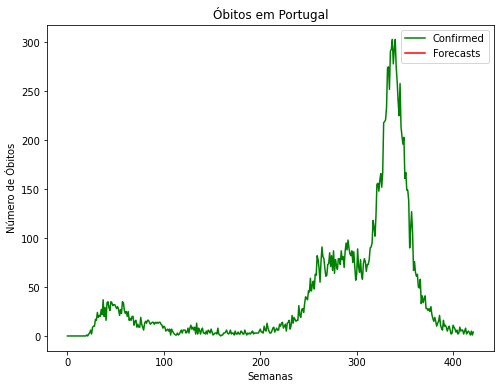

[array([[73.26894]], dtype=float32)]


In [15]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

n_variate = 4 #1, 2, 3  # number of features used by the model (using conf. cases to predict conf. cases) 

#the dataframes

df_raw = load_dataset('../Datasets_utilizados/dataset_final.csv')
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)
plot_confirmed_cases(df_data) #the plot you saw previously
scaler = data_normalization(df) #scaling data to [-1,1]


##Optimization

tunning_dict = {               
                1: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 25,  'batch_size' : 1 , "learning_rate":0.001},
                2: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 2 ,"learning_rate":0.0001},
                3: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 3 ,"learning_rate":0.00001},

                
                4: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 1 ,"learning_rate":0.001},
                5: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                6: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001},
                
                7: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 1 ,"learning_rate":0.001},
                8: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                9: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001}

                }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
    # print(record[r])
    # fitting the model
    timesteps = tunning_dict[t]['timesteps']
    epochs = tunning_dict[t]['epochs']
    batch_size = tunning_dict[t]['batch_size']
    multisteps = tunning_dict[t]['multisteps']
    cv_splits = tunning_dict[t]['cv_splits']
    learning_rate = tunning_dict[t]['learning_rate']
    # print(timesteps,epochs,batch_size,cv_splits)

    X, y = to_supervised(df, timesteps)

    model = build_model(timesteps, n_variate)
    model, history = compile_and_fit(model, epochs, batch_size,learning_rate)
    path_to_save=r'modelo_'+str(t)+'.h5'
    model.save(path_to_save)
    # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
    forecasts = forecast(model, df, timesteps, multisteps, scaler)
    plot_forecast(df_data, forecasts)
    print(forecasts)

    prev = []

    record[t] = history


  #Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
        # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
        # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
        # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
        # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
        loss.append(sum(h.history['loss']) / len(h.history['loss']))
        mae.append(sum(h.history['mae']) / len(h.history['mae']))
        rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
        val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
        val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
        val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
        id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1




In [16]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.061840558884044494, 0.06184055966635545, 0.061840558884044494, 0.09864037654052178, 0.09864037654052178, 0.09864037654052178] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.0832440302024285, 0.0792808823287487, 0.08319127192099889, 0.2008802314226826, 0.18699684669574101, 0.2045987718428175] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.06808476343750954, 0.06214636233324806, 0.06808476362377405, 0.20308392585565646, 0.18710194377228617, 0.21323491397624214] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.04883360122330487, 0.048833601611355935, 0.04883360122330487, 0.11652481165818042, 0.1165248118237489, 0.11652481165818042] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.07549745263186869, 0.07235582695791015, 0.07543853991147544, 0.14392216924784912, 0.13651681685889208, 

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.061841,0.061841,0.061841,0.098640,0.098640,0.098640
2,0.083244,0.079281,0.083191,0.200880,0.186997,0.204599
3,0.068085,0.062146,0.068085,0.203084,0.187102,0.213235
4,0.048834,0.048834,0.048834,0.116525,0.116525,0.116525
5,0.075497,0.072356,0.075439,0.143922,0.136517,0.147263
6,0.108152,0.097902,0.108152,0.202707,0.187129,0.204934
7,0.047317,0.047317,0.047317,0.148868,0.148868,0.148868
8,0.079366,0.075826,0.079357,0.162857,0.152333,0.160587
9,0.070490,0.062229,0.070490,0.190862,0.173677,0.192452


In [17]:
#Results metrics to a file
final_df.to_csv(r"resultados_cnn_covid.csv",index=True)